In [97]:

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot

from dataset import TarFLCDataset
from modules.transforms import SimCLRTransform
from main import SimCLR
from backbones import get_backbone

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

# Use a resnet backbone.
MODEL = "simclr-resnet18-STED"
MODEL = "IMAGENET1K_V1"
MODEL = "MICRA-Net"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False

if MODEL == "simclr-resnet18-STED":
    transform = None
    backbone = get_backbone("resnet18")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        print("Restoring model...")
        model.load_state_dict(ckpt)
elif MODEL == "MICRA-Net":
    transform = None
    backbone = get_backbone("micranet")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        print("Restoring model")
        model.load_state_dict(ckpt)
    
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval();
print("Model loaded")

Restoring model
Model loaded


/tmp/ipykernel_80908/1164937825.py:25: UserWarning: Overwriting the cmap 'nice-prism' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_80908/1164937825.py:26: UserWarning: Overwriting the cmap 'nice-prism_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)


In [113]:
def filter_files(class_folder, apply_filter=True):
    files = os.listdir(class_folder)
    filtered_files = []

    for file in files:
        match = re.search(r"-(\d+\.\d+)\.npz", file)
        if match:
            quality_score = float(match.group(1))
            if not apply_filter or quality_score >= 0.70:
                filtered_files.append(file)

    return filtered_files

class CreateDataset(Dataset):
    """
    Dataset class for loading and processing image data from different classes.
        
    Args:
        data_folder (str): path to the root data folder containing subfolders for each class.
        num_samples (dict or None): number of samples to randomly select from each class.
        transform (callable, optional): transformation to apply on each image.
        apply_filter (bool): choose to filter files based on quality score or not.
        classes (list): list of class names present in the dataset.
    """
    def __init__(self, data_folder, num_samples=None, transform=None, apply_filter=False, classes=['actin','tubulin','CaMKII','PSD95'], requires_3_channels=False):
        self.data_folder = data_folder
        self.num_samples = num_samples
        self.transform = transform
        self.apply_filter = apply_filter
        self.classes = classes
        self.requires_3_channels = requires_3_channels

        self.class_files = {}
        self.sampled_files = {}

        random.seed(20)
        numpy.random.seed(20)

        # Loop through each class and process files
        for class_name in classes:
            class_folder = os.path.join(data_folder, class_name)
            # Filter files
            self.class_files[class_name] = self.filter_files(class_folder)
             # Randomly sample files based on num_samples
            self.sampled_files[class_name] = self.get_sampled_files(self.class_files[class_name], self.num_samples.get(class_name))
        
        for key, values in self.sampled_files.items():
            print(key, len(values))

    def filter_files(self, class_folder):
        # Filter files based on quality score in filename
        SCORE = 0.70
        files = glob.glob(os.path.join(class_folder, "**/*.npz"), recursive=True)
        filtered_files = []

        for file in files:
            match = re.search(r"-(\d+\.\d+)\.npz", file)
            if match:
                quality_score = float(match.group(1))
                if not self.apply_filter or quality_score >= SCORE:
                    filtered_files.append(file)
        return filtered_files

    def get_sampled_files(self, files_list, num_sample):
        if num_sample is not None:
            return random.sample(files_list, num_sample)
        else:
            return files_list

    def __len__(self):
        # Compute total of samples in the dataset
        total_length = sum(len(self.sampled_files[class_name]) for class_name in self.classes)
        return total_length

    def __getitem__(self, idx):
        class_name = None
        class_index = None
        index = None
        
        dataset_idx = idx

        for i, class_name in enumerate(self.classes):
            if idx < len(self.sampled_files[class_name]):
                file_name = self.sampled_files[class_name][idx]
                class_folder = class_name
                class_index = i
                index = idx
                break
            else:
                idx -= len(self.sampled_files[class_name])
        
#         path = os.path.join(self.data_folder, class_folder, file_name)
        path = file_name
        label = class_index
        
        match = re.search(r"-(\d+\.\d+)\.npz", path)
        if match:
            quality_score = float(match.group(1))

        data = numpy.load(path)
        image = data['arr_0']
        
        m, M = numpy.quantile(image, [0.01, 0.995])
        m, M = image.min(), image.max()
        image = (image - m) / (M - m)
        if self.requires_3_channels:
            image = numpy.tile(image[numpy.newaxis], (3, 1, 1))
        else:
            image = image[numpy.newaxis]
        image = torch.tensor(image, dtype=torch.float32)        
        
        if self.transform:
            image = self.transform(image)
        
        return image, {"label" : label, "dataset-idx" : dataset_idx, "score" : quality_score}

In [114]:

dataset = CreateDataset(
    "./data/ssl/testdata", 
    num_samples={'actin':None, 'tubulin':None, 'CaMKII_Neuron':None, 'PSD95_Neuron':None}, 
    transform=transform, apply_filter=False, requires_3_channels=REQUIRES_3_CHANNELS,
    classes=['actin', 'tubulin', 'CaMKII_Neuron', 'PSD95_Neuron']
)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=16,
    shuffle=True,
    num_workers=1
)

actin 534
tubulin 105
CaMKII_Neuron 125
PSD95_Neuron 99


In [115]:
out = defaultdict(list)
for x, label in tqdm(dataloader):
    features = model.backbone(x).flatten(start_dim=1)
    for key, values in label.items():
        out[key].extend(values.cpu().data.numpy().tolist())
    out["features"].extend(features.cpu().data.numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [01:09<00:00,  1.28s/it]


In [122]:
import phate 
samples = numpy.array(out["features"])
labels = numpy.array(out["label"])
indices = numpy.array(out["dataset-idx"])
quality = numpy.array(out["score"])

phate_op = phate.PHATE(random_state=42)
X_transformed = phate_op.fit_transform(samples)

Calculating PHATE...
  Running PHATE on 863 observations and 256 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.23 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.35 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 0.41 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.16 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.59 seconds.
Calculated PHATE in 1.51 seconds.


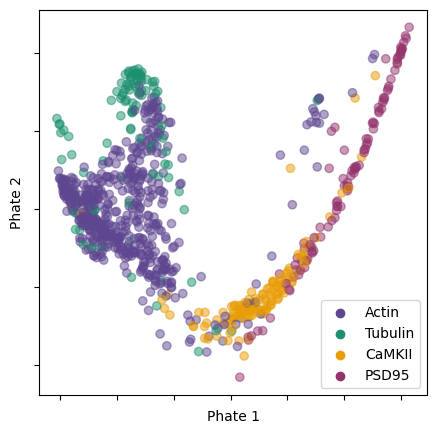

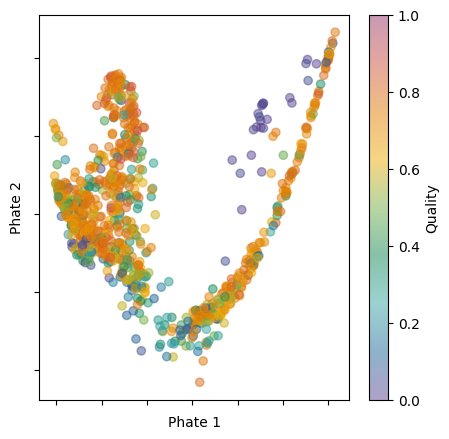

In [125]:
%matplotlib inline
fig, ax = pyplot.subplots(figsize=(5, 5))
ax.scatter(*X_transformed.T, c=labels, cmap="nice-prism", alpha=0.5)
ax.set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cmap = pyplot.get_cmap("nice-prism", len(numpy.unique(labels)))
ax.legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=["Actin", "Tubulin", "CaMKII", "PSD95"]
)
pyplot.show()

fig, ax = pyplot.subplots(figsize=(5, 5))
sc = ax.scatter(*X_transformed.T, c=quality, cmap="nice-prism", alpha=0.5, vmin=0, vmax=1)
ax.set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cbar = pyplot.colorbar(sc, ax=ax)
cbar.set_label("Quality")
pyplot.show()

<IPython.core.display.Javascript object>


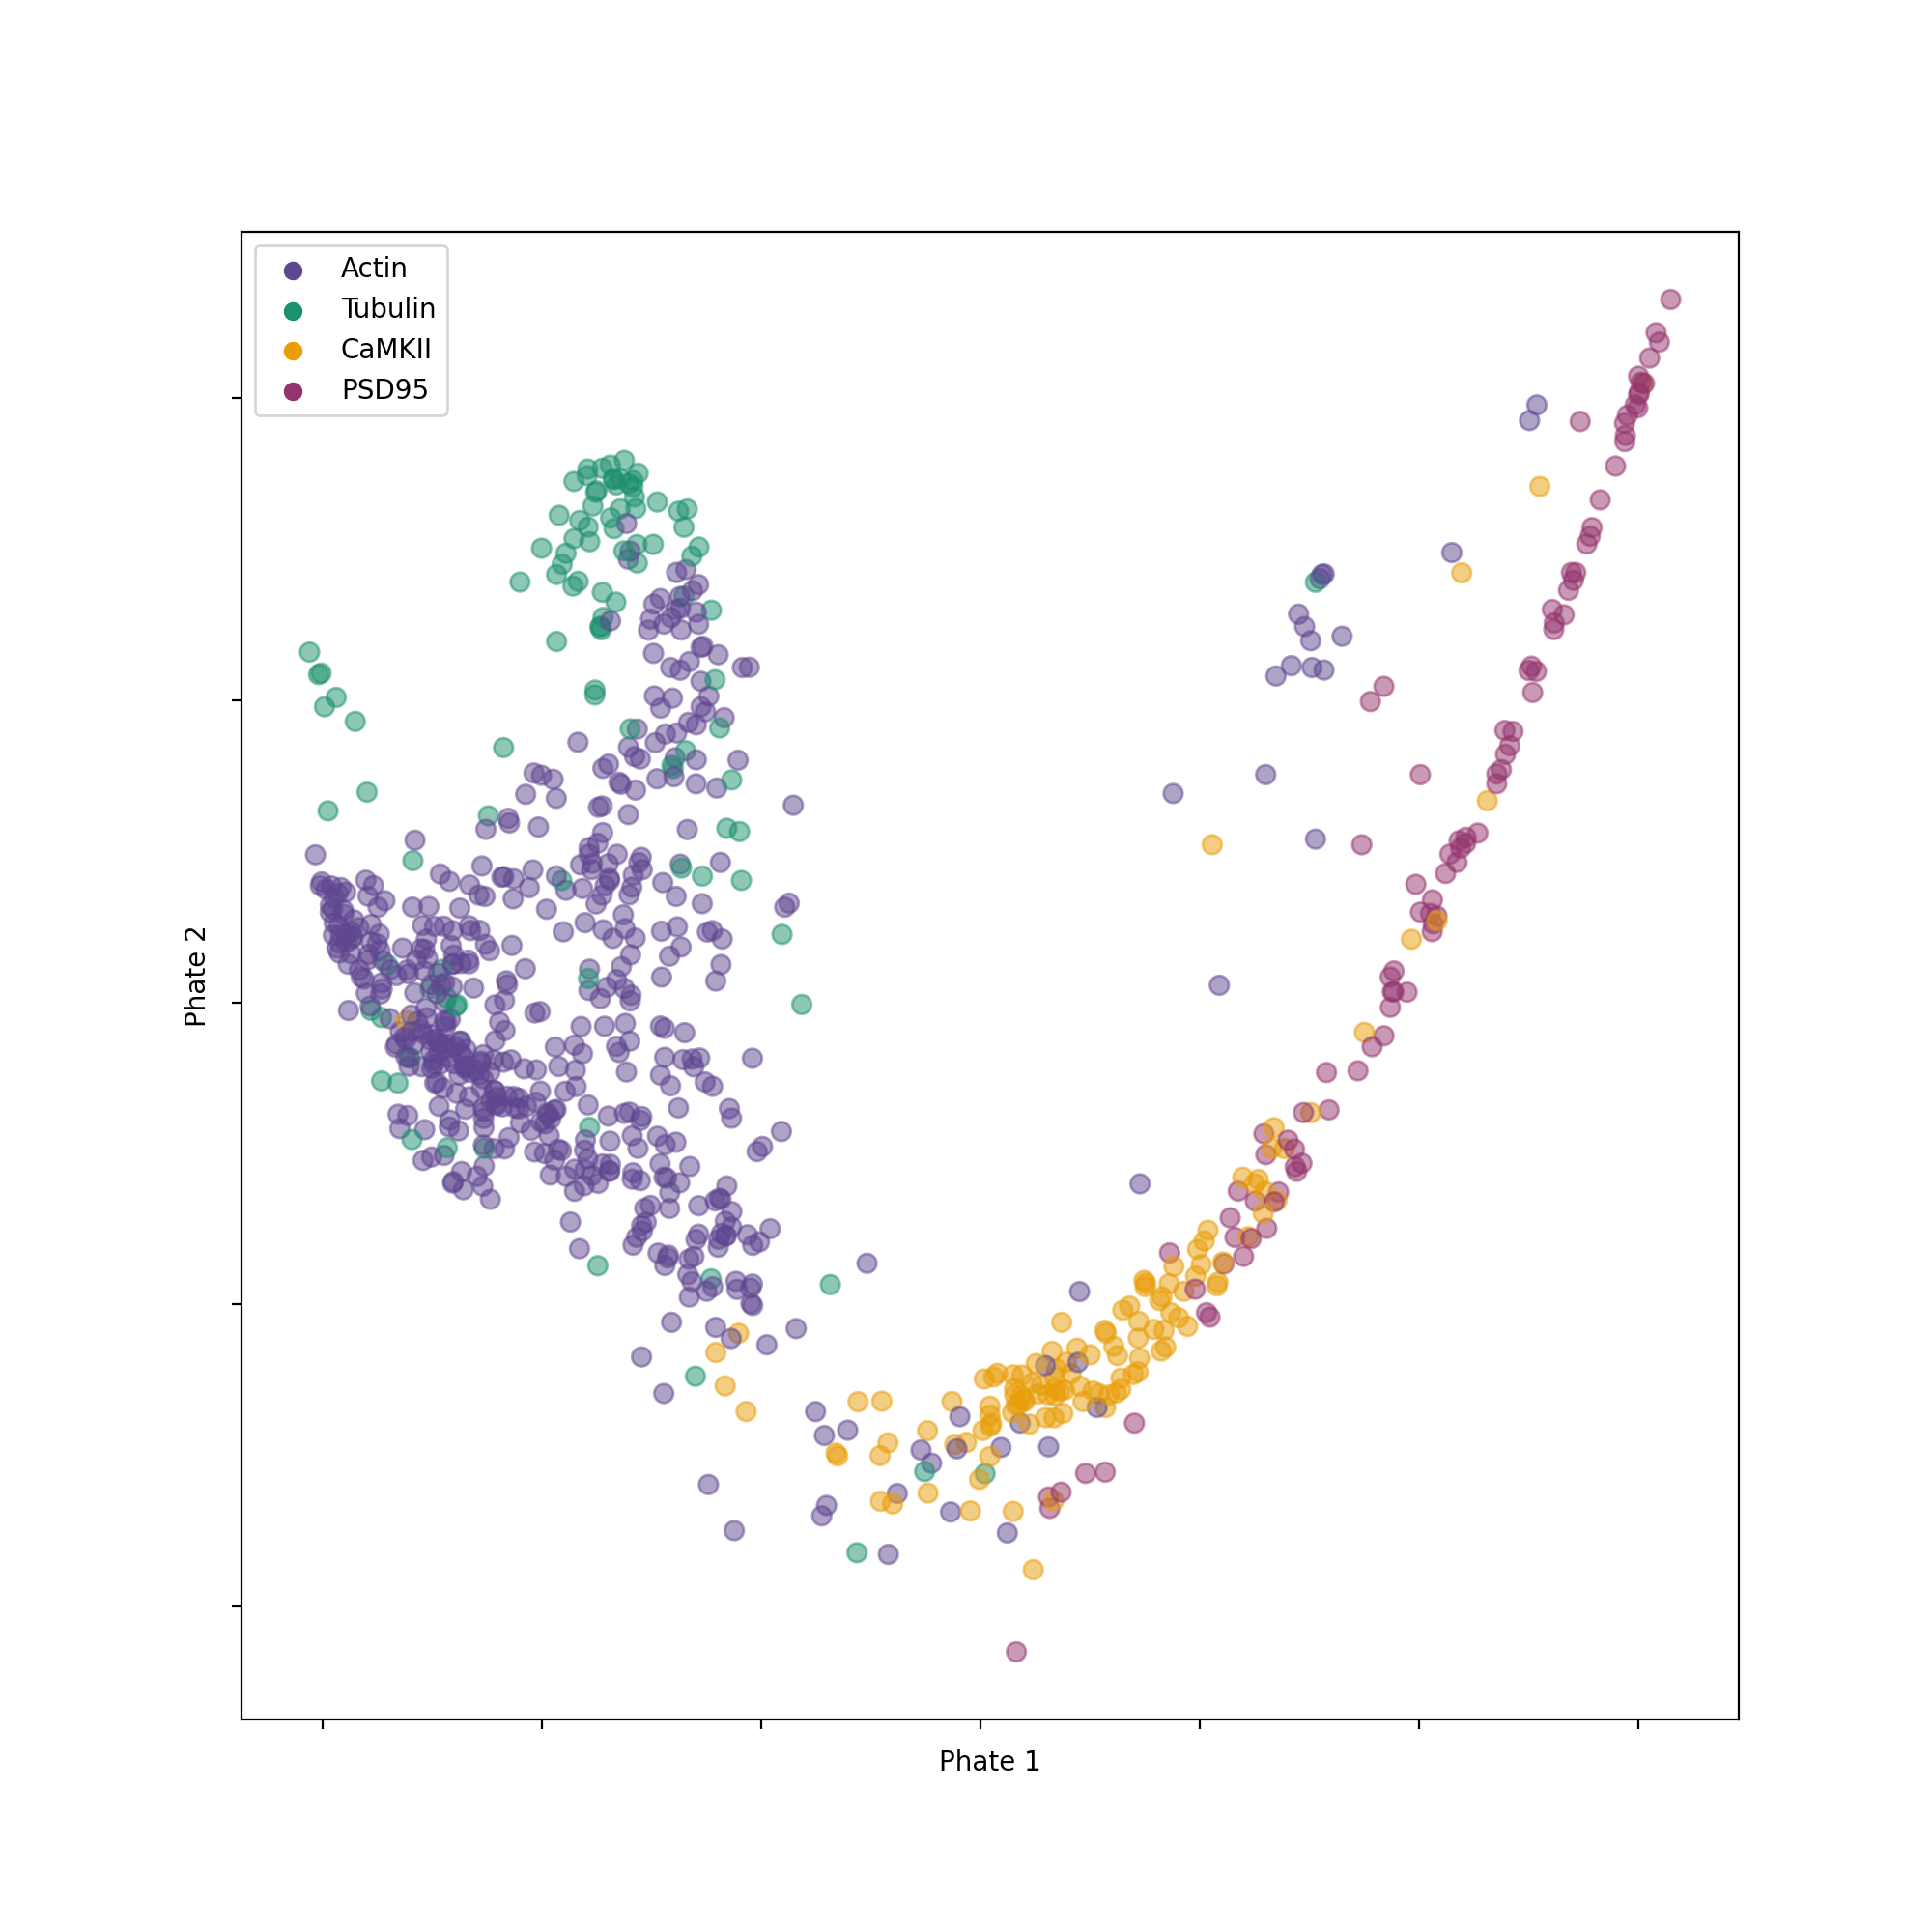

In [126]:
%matplotlib notebook

import ipywidgets
from matplotlib import colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = pyplot.subplots(figsize=(10, 10))
ax.scatter(*X_transformed.T, c=labels, cmap="nice-prism", alpha=0.5, s=50)
ax.set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cmap = pyplot.get_cmap("nice-prism", len(numpy.unique(labels)))
ax.legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=["Actin", "Tubulin", "CaMKII", "PSD95"]
)

# Creates the annotation box
norm = colors.Normalize(vmin=0, vmax=1)
im = OffsetImage(dataset[0][0].numpy().squeeze(), zoom=0.5, cmap="hot", norm=norm)
ab = AnnotationBbox(
    im, (0, 0), xybox=(75, 75), xycoords='data',
    boxcoords="offset points", frameon=False,
    arrowprops=dict(
        arrowstyle="-",
        connectionstyle="angle,angleA=0,angleB=90,rad=3")
)

# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):

    # Gets scatter points from ax
    sc = ax.collections[0]    

    contains, index = sc.contains(event)
    if contains:
        # May have multiple points in array
        index = index["ind"][0]
        # Sets the new position
        ab.xy = (X_transformed[index])

        sizes = numpy.ones(len(X_transformed)) * 50
        sizes[index] = 200
        sc.set_sizes(sizes)
        
        # Images are randomly shuffled, needs the index in dataset
        index = indices[index]
        im.set_data(dataset[index][0].numpy().squeeze())
        ab.set_visible(True)
    else:
        sizes = numpy.ones(len(X_transformed)) * 50
        sc.set_sizes(sizes)        

        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)
pyplot.show(block=True)